<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/ComputerVision/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set installation txt file with all relevant packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import shutil
import random
import imghdr

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [30]:
#tf.debugging.set_log_device_placement(True)

if tf.config.list_physical_devices('GPU'):
  if len(tf.config.list_physical_devices('GPU')) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
  else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# download images folder
#!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
#from shutil import unpack_archive
#unpack_archive('/content/flower_photos.tgz', '/content/')

--2021-06-13 13:22:15--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   100MB/s    in 2.2s    

2021-06-13 13:22:17 (100 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [4]:
# load data parameters

MAX_WIDTH, MAX_HEIGHT = 100, 100
ORIGIN = os.path.dirname(os.path.abspath("ImageClassification.ipynb"))
print(ORIGIN)
SOURCE = 'flower_photos'
#test_path = ''
# available color modes are "grayscale", "rgb", "rgba", 
# (images will be converted to have 1, 3, or 4 channels)
COLOR_MODE = "rgb"
SOURCE_PATH = os.path.join(ORIGIN, SOURCE)
#test_source_folder_path = os.path.join(ORIGIN, test_path)
print(SOURCE_PATH)

BATCH_SIZE = 32
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2
SEED = 100

IMAGE_EXTENSIONS = ['png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif']


/content
/content/flower_photos


In [5]:
# split dataset on test and train if is not currently

def train_test_split():
  """
  Create train and test subsets from source dataset.
  """

  source_path = os.path.join(ORIGIN, SOURCE_PATH)
  train_path = "train_data"
  test_path = "test_data"
  train_path = os.path.join(ORIGIN, train_path)
  test_path = os.path.join(ORIGIN, test_path)

  if os.path.exists(train_path):
    shutil.rmtree(train_path)
  os.mkdir(train_path)

  if os.path.exists(test_path):
    shutil.rmtree(test_path)
  os.mkdir(test_path)

  for dir in os.listdir(source_path):
    files = os.listdir(os.path.join(source_path, dir))
    if len(files) > 0:
      # create train dataset dir
      if not os.path.exists(os.path.join(train_path, dir)):
        os.mkdir(os.path.join(train_path, dir))
      # create test dataset dir
      if not os.path.exists(os.path.join(test_path, dir)):
        os.mkdir(os.path.join(test_path, dir))
      # extract names of test subset files
      test_num = len(files) * TEST_SPLIT
      indicies = random.sample(range(len(files)), round(test_num))
      test_files_names = [files[i] for i in indicies]
      
      for f in files:
        if f in test_files_names:
          # move file from source dataset to test dataset
          image_type = imghdr.what(os.path.join(os.path.join(source_path, dir), f))
          if image_type in IMAGE_EXTENSIONS:
            os.replace(os.path.join(os.path.join(source_path, dir), f), 
                       os.path.join(os.path.join(test_path, dir), f))
        
        else:
          # move file from source dataset to test dataset
          image_type = imghdr.what(os.path.join(os.path.join(source_path, dir), f))
          if image_type in IMAGE_EXTENSIONS:
            os.replace(os.path.join(os.path.join(source_path, dir), f), 
                       os.path.join(os.path.join(train_path, dir), f))
      
      

  return train_path, test_path


In [6]:
def get_min_img_size(train_path, test_path=None):
  """
  Check if all images are of the same size and get min image width and min image
  height.
  param train_path:              path of a train source folder
  param test_path:               path of a test source folder
  return img_width, img_height:  min image width and height scalar values
  """

  img_width_list = []
  img_height_list = []

  def get_image_params(data_path):
    img_width, img_height = None, None
    dirs = os.listdir(data_path)
    for dir in dirs:
      files = os.listdir(data_path + "/" + dir)
      for f in files:
        image_path = data_path + "/" + dir + "/" + f
        image = tf.keras.preprocessing.image.load_img(image_path)
        image = keras.preprocessing.image.img_to_array(image)
        if img_width == None:
          img_width, img_height = image.shape[0], image.shape[1]
        else:
          if image.shape[0] < img_width:
            img_width = image.shape[0]
          if image.shape[1] < img_height:
            img_height = image.shape[1]

    return img_width, img_height

  if test_path == None:
    return get_image_params(train_path)
    
  else:
    img_width_train, img_height_train = get_image_params(train_path)
    img_width_list.append(img_width_train)
    img_height_list.append(img_height_train)

    img_width_test, img_height_test = get_image_params(test_path)
    img_width_list.append(img_width_test)
    img_height_list.append(img_height_test)
  
    return min(img_width_list), min(img_height_list)

In [7]:
def set_resize_image_parameters(img_width, img_height):
  """
  Set parameters for resizing input images.
  param img_width, img_height:   image height and image with scalar values
  return img_width, img_height:  resized image height and image with scalar values     
  """

  if img_width > MAX_WIDTH:
    img_width = MAX_WIDTH

  if img_height > MAX_HEIGHT:
    img_height = MAX_HEIGHT
  
  return img_height, img_width



In [8]:
# set tensorflow dataset parameters
# remove unneccessary files from source directory
train_path, test_path = train_test_split()
img_width, img_height = get_min_img_size(train_path, test_path=test_path)
img_width, img_height = set_resize_image_parameters(img_height, img_width)
image_size = (img_width, img_height)
print(image_size)

(100, 100)


In [9]:
def get_image_dataset(data_path, image_size, subset = None):
  """
  Create tensorflow dataset from data directory object.
  param data_path:        string, source folder path
  param image_size:       touple (image_with, image_height)
  param subset:           optional, name of subset ('train', 'validation')
  return dataset:         dict, tensorflow dataset and class names
  """
    
  if subset:
    validation_split = VALIDATION_SPLIT
    seed = SEED
  
  else:
    validation_split = None
    seed = None

  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      color_mode=COLOR_MODE,
      image_size=image_size,
      batch_size=BATCH_SIZE,
      seed=seed,
      validation_split=validation_split, 
      subset=subset
    )
    
  dataset.class_names.sort()
    
  return {
      "data": dataset.cache().prefetch(
      buffer_size = tf.data.AUTOTUNE
      ),
      "classNames": dataset.class_names
        }

In [35]:

training_ds = get_image_dataset(
    train_path,
    image_size,
    subset = "training"
)

validation_ds = get_image_dataset(
    train_path,
    image_size,
    subset = "validation"
)


test_ds = get_image_dataset(
    test_path,
    image_size
)


Found 2935 files belonging to 5 classes.
Using 2348 files for training.
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummyMemoryCache in devi

In [36]:
def check_data(training_ds, validation_ds, test_ds):

  # check does training and validation datasets contains same classes
  validation_check = training_ds["classNames"] == validation_ds["classNames"]
  assert_fail_message = "Training and Validation classes should match. "
  assert(validation_check), assert_fail_message

  # check does training and test datasets contains same classes
  test_check = training_ds["classNames"] == test_ds["classNames"]
  assert_fail_message = "Training and Test classes should match. "
  assert(test_check), assert_fail_message

  class_names = training_ds["classNames"]
  number_classes = len(class_names)
  print(training_ds["classNames"])
  print(validation_ds["classNames"])
  print(test_ds["classNames"])

  return class_names

In [37]:
class_names = check_data(training_ds, validation_ds, test_ds)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [47]:
def visualize_dataset(dataset):
  """
  Visualize input images.
  param dataset: tensorflow dataset objects
  """

  image_shape = []
  plt.figure(figsize=(10, 10))
  
  # take first batch (batch_size = num_of_images = num_of_labels)
  # labels are label encoded
  # images are unscaled (0 - 255) 4D tensors (batch_size, width, height, chanells)
  for images, labels in dataset.take(1):
    # take first 9 images and labels from first batch
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  
  for image_batch, labels_batch in dataset.take(1):
    image_shape = [image_batch.shape[1], image_batch.shape[1], 
                   image_batch.shape[2], image_batch.shape[3]]
    print("Image batch shape is {}".format(image_batch.shape))
    print("Label batch shape is {}".format(labels_batch.shape))
    break
  
  return image_shape

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op S

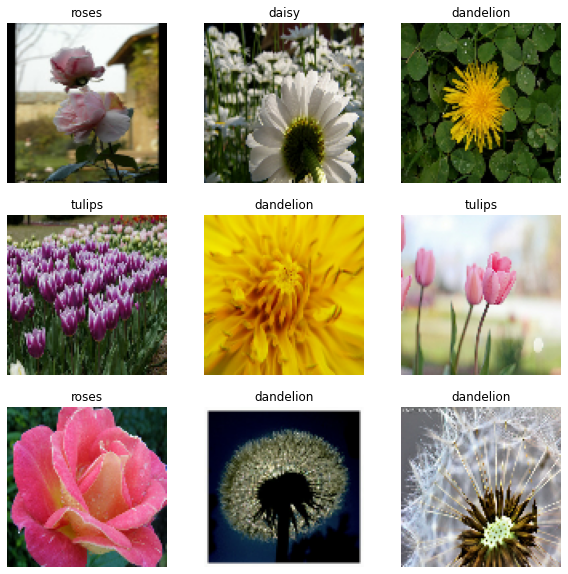

In [48]:
image_shape = visualize_dataset(training_ds['data'])

In [49]:
def normalize_input_data(dataset):
  """
  Rescale input dataset in range [0, 1].
  param dataset: tensorflow dataset
  return normalized_dataset: normalized input dataset
  """
  normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
  normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))
  return normalized_ds

In [51]:
train_dataset = normalize_input_data(training_ds['data'])
val_dataset = normalize_input_data(validation_ds['data'])
test_dataset = normalize_input_data(test_ds['data'])

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
# check number of samples in each class - done this in loading dataset
# add data augmentation step

In [41]:
def create_model(hp, image_shape):
  """
  Create and compile model. Use keras functional API.
  param image_shape: list of one image input shape parameters
  """

  # define hyper-parameters for tuning
  hp_units = hp.Int('hp_units', min_value=32, max_value=128, step=16)

  inputs = keras.Input(shape=(image_shape[1], image_shape[2], image_shape[3]), 
                       batch_size=image_shape[0], name="input_img")
  
  x = layers.Conv2D(32, 3, activation="relu")(inputs)
  x = layers.Conv2D(64, 3, activation="relu")(x)
  block_1_output = layers.MaxPooling2D(3)(x)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_2_output = layers.add([x, block_1_output])
  normalized_1 = layers.normalization.BatchNormalization()(block_2_output)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(normalized_1)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_3_output = layers.add([x, normalized_1])
  normalized_2 = layers.normalization.BatchNormalization()(block_3_output)

  x = layers.Conv2D(filters=hp_units, 3, activation="relu")(normalized_2)
  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dense(units=hp_units, activation="relu")(x)
  x = layers.Dropout(rate=hp.Float(
                    'dropout_1',
                    min_value=0.1,
                    max_value=0.5,
                    default=0.25,
                    step=0.1,
                    ))(x)

  outputs = layers.Dense(len(class_names),
                         kernel_regularizer=regularizers.l2(1e-4),
                         bias_regularizer=regularizers.l2(1e-4))(x)

  model = keras.Model(inputs, outputs, name="image_classifier")

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

In [46]:
print(image_shape)

[100, 100, 3]
